# Импорты

In [ ]:
!pip install tensorflow==2.9.1

In [3]:

import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


# Предварительная обработка данных

**Считайте данные и сохраните их в dataframe**

In [6]:
# Создание путей к данным с метками
data_dir = 'dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Объединить пути данных с метками в один кадр данных.
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [13]:
df

,filepaths,labels
0,dataset\fogsmog\4075.jpg,fogsmog
1,dataset\fogsmog\4076.jpg,fogsmog
2,dataset\fogsmog\4077.jpg,fogsmog
3,dataset\fogsmog\4078.jpg,fogsmog
4,dataset\fogsmog\4079.jpg,fogsmog
...,...,...
3334,dataset\sunrise\sunrise197.jpg,sunrise
3335,dataset\sunrise\sunrise23.jpg,sunrise
3336,dataset\sunrise\sunrise7.jpg,sunrise
3337,dataset\sunrise\sunrise81.jpg,sunrise


**Разделить фрейм данных на обучающий, действительный и тестовый**

In [7]:
# обучающий dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# действительный и тестовый dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Создать генератор данных изображения**

In [8]:
# обрезанный размер изображения
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Эта функция, которая будет использоваться в генераторе данных изображений для увеличения данных, просто берет изображение и возвращает его снова.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 2671 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 268 validated image filenames belonging to 8 classes.


**Показ образцов данных**

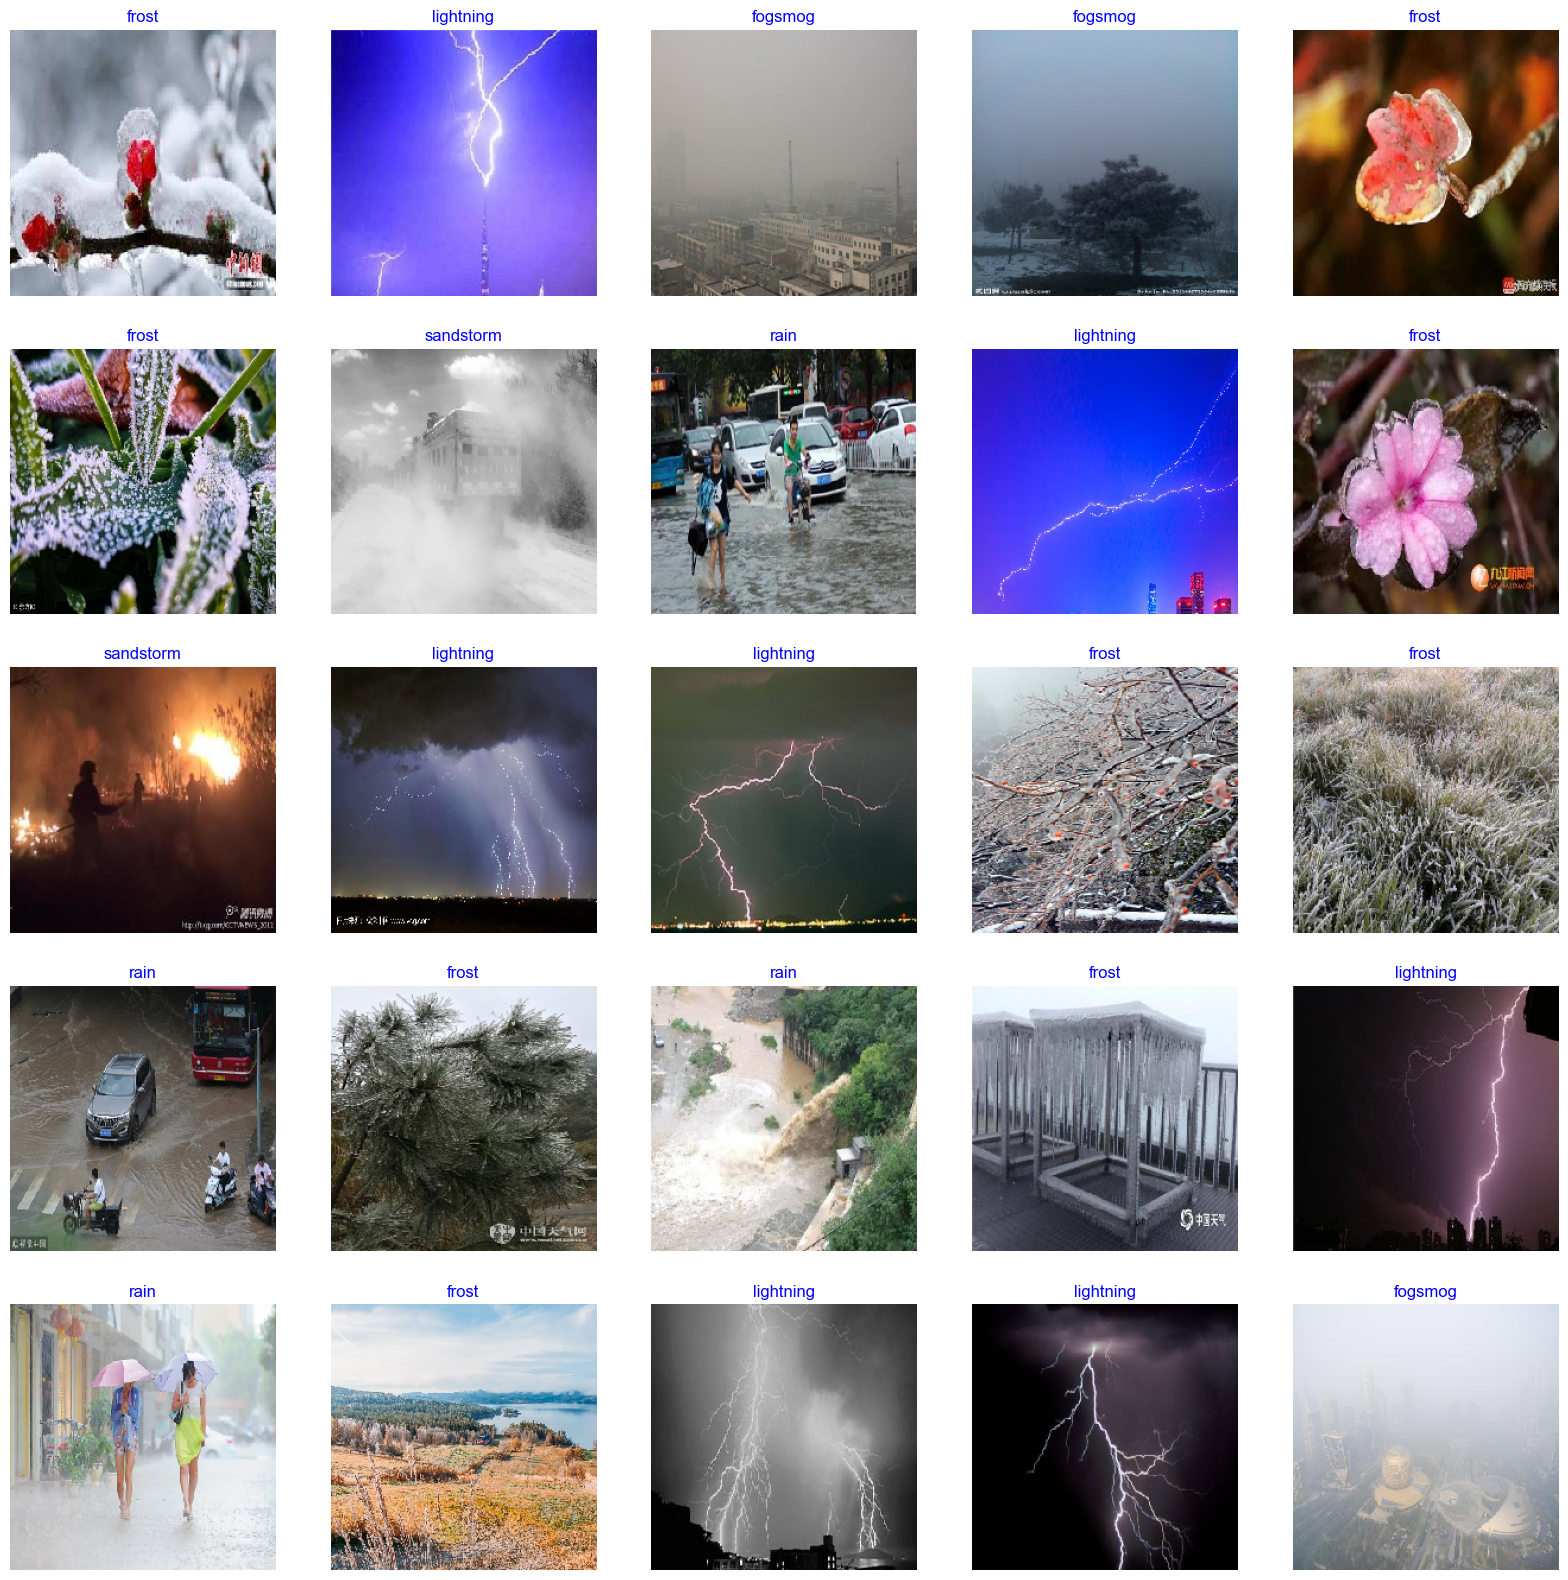

In [16]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

length = len(labels)        
sample = min(length, 25)    

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Структура модели

**Создание общей модели**

In [17]:
# Создать структуру модели
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 


base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 11185207 (42.67 MB)
Trainable params: 11

# Модель

In [18]:
epochs = 20   # чисор всех эпох

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
42/42 [==============================] - 285s 6s/step - loss: 7.8134 - accuracy: 0.8064 - val_loss: 6.9177 - val_accuracy: 0.9350
Epoch 2/20
42/42 [==============================] - 262s 6s/step - loss: 5.9560 - accuracy: 0.9614 - val_loss: 5.3902 - val_accuracy: 0.9625
Epoch 3/20
42/42 [==============================] - 261s 6s/step - loss: 4.7987 - accuracy: 0.9757 - val_loss: 4.3709 - val_accuracy: 0.9775
Epoch 4/20
42/42 [==============================] - 261s 6s/step - loss: 3.9244 - accuracy: 0.9880 - val_loss: 3.5806 - val_accuracy: 0.9775
Epoch 5/20
42/42 [==============================] - 261s 6s/step - loss: 3.2420 - accuracy: 0.9876 - val_loss: 2.9610 - val_accuracy: 0.9775
Epoch 6/20
42/42 [==============================] - 261s 6s/step - loss: 2.6791 - accuracy: 0.9914 - val_loss: 2.4529 - val_accuracy: 0.9750
Epoch 7/20
42/42 [==============================] - 261s 6s/step - loss: 2.2254 - accuracy: 0.9944 - val_loss: 2.0524 - val_accuracy: 0.9725
Epoch 8/20
42

**Отображение производительности модели**

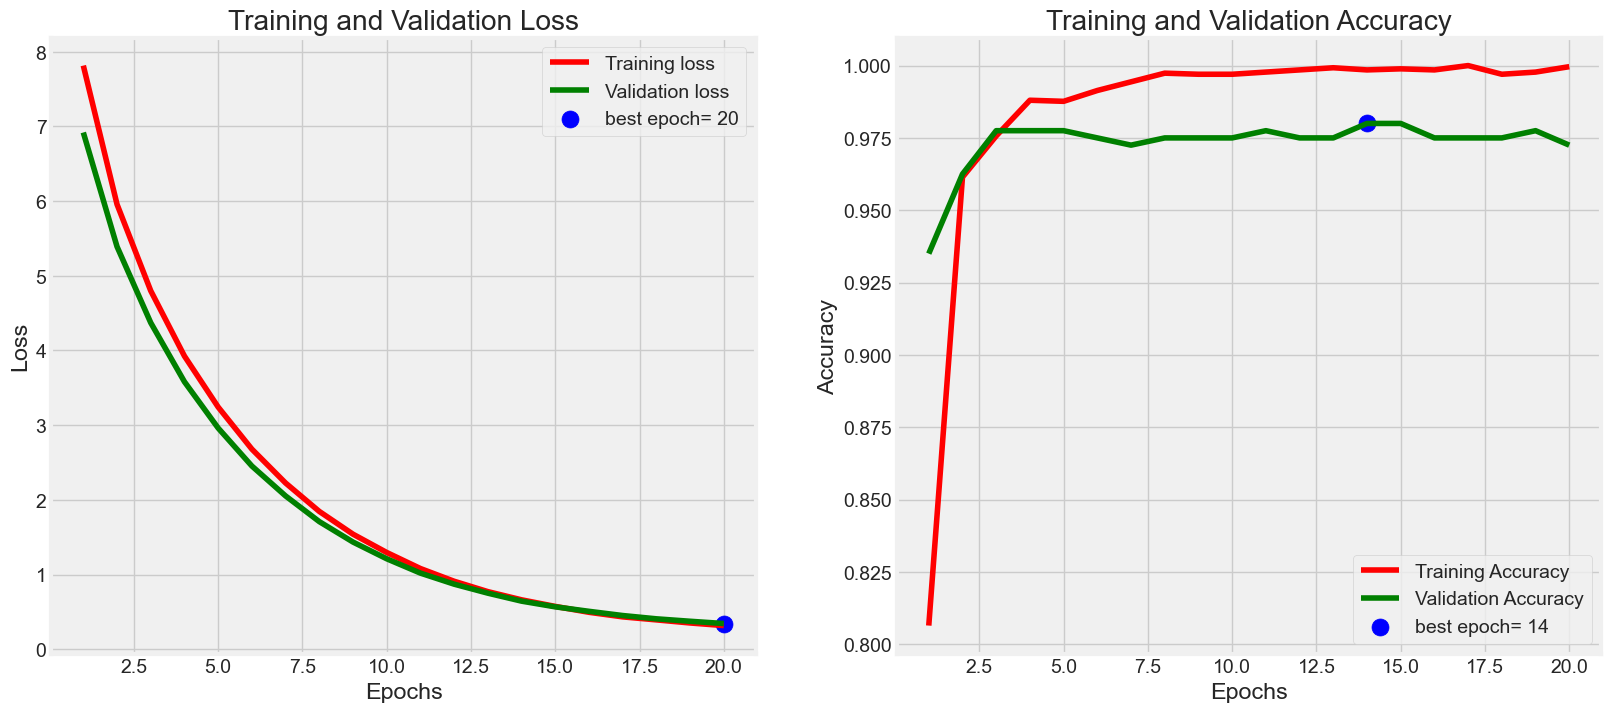

In [19]:
# Объявляем переменные
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Строим графики
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Оцениваем модель

In [20]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 6s 1s/step - loss: 0.3989 - accuracy: 0.9590
Train Loss:  0.26669108867645264
Train Accuracy:  1.0
--------------------
Validation Loss:  0.36070716381073
Validation Accuracy:  0.97265625
--------------------
Test Loss:  0.39886474609375
Test Accuracy:  0.9589552283287048


**Получение прогнозов**

In [21]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Матрица и отчет о классификации**

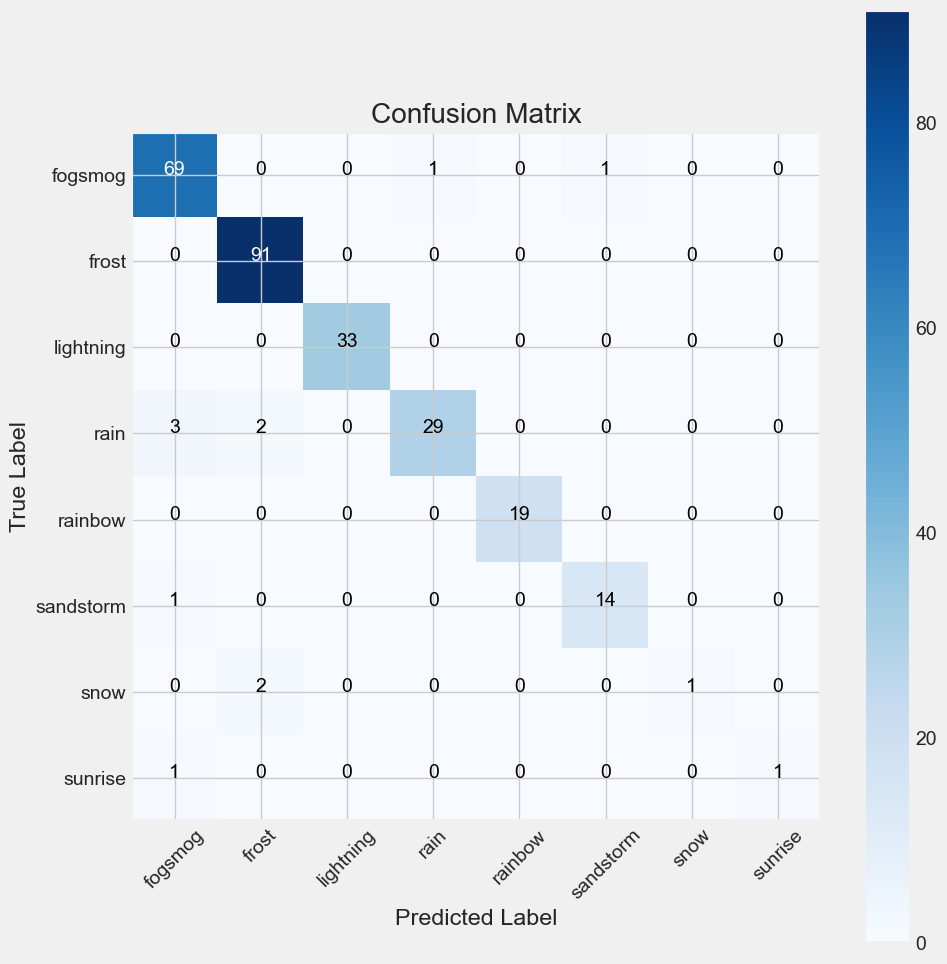

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Матрица ответов
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [23]:
# Отчет класиффикации
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

     fogsmog       0.93      0.97      0.95        71
       frost       0.96      1.00      0.98        91
   lightning       1.00      1.00      1.00        33
        rain       0.97      0.85      0.91        34
     rainbow       1.00      1.00      1.00        19
   sandstorm       0.93      0.93      0.93        15
        snow       1.00      0.33      0.50         3
     sunrise       1.00      0.50      0.67         2

    accuracy                           0.96       268
   macro avg       0.97      0.82      0.87       268
weighted avg       0.96      0.96      0.96       268



**Сохранение**

In [ ]:
model.save('MIptCats.h5')

# Прогнозирование с использованием загруженной модели

In [4]:
loaded_model = tf.keras.models.load_model('MIptCats.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [9]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

image_path = 'test_data/11.jpg'
image = Image.open(image_path)

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

image_path = 'test_data/1830.jpg'
image = Image.open(image_path)

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

image_path = 'test_data/1688761400_kartin-papik-pro-p-kartinki-vechernii-dozhd-52.jpg'
image = Image.open(image_path)

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 67ms/step
rain
1/1 [==============================] - 0s 67ms/step
lightning
1/1 [==============================] - 0s 67ms/step
rain
